# Compton Effekt

## initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks
import scienceplots
plt.figure()
plt.style.use('science')
import os
if not os.path.exists('Compton/output'):
    os.makedirs('Compton/output')

<Figure size 640x480 with 0 Axes>

In [2]:
# normalize
def normalize(arr, t_min, t_max):
    arr = arr.to_numpy()
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    arr = arr.to_numpy()
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    arr = arr.to_numpy()
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Kalibrierung

### import data

In [3]:
co60_kalib = pd.read_csv('Compton/data_alt/Kalibrierung_Punkt1/Co60_Kalibrierung.txt', sep='\t', header=None, names=['channel', 'counts'])
cs137_kalib = pd.read_csv('Compton/data_alt/Kalibrierung_Punkt1/Cs137_Kalibrierung.txt', sep='\t', header=None, names=['channel', 'counts'])
na22_kalib = pd.read_csv('Compton/data_alt/Kalibrierung_Punkt1/Na22_Kalibrierung.txt', sep='\t', header=None, names=['channel', 'counts'])
co60_kalib

,channel,counts
0,0,132
1,1,752
2,2,725
3,3,717
4,4,768
...,...,...
251,251,6
252,252,6
253,253,7
254,254,9


### analyze data

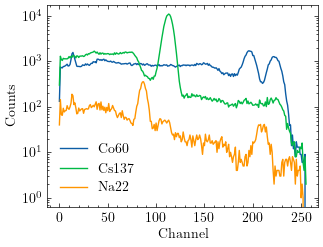

In [4]:
plt.plot(co60_kalib['channel'], co60_kalib['counts'], label='Co60')
plt.plot(cs137_kalib['channel'], cs137_kalib['counts'], label='Cs137')
plt.plot(na22_kalib['channel'], na22_kalib['counts'], label='Na22')
plt.legend()

plt.xlabel('Channel')
plt.ylabel('Counts')

plt.yscale('log')

## 2 Streuwinkel

### import data

In [5]:
streuwinkel = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]
streuwinkel = unp.uarray(streuwinkel,0.5)
streu_data = []*len(streuwinkel)
for i in streuwinkel:
    streu_data.append(pd.read_csv(f'Compton/data_alt/Streuwinkel_Punkt2/Cs137_{int(i.n)}grad.txt', sep='\t', header=None, names=['channel', 'counts']))
streu_data[len(streu_data)-1]

,channel,counts
0,0,4
1,1,19
2,2,9
3,3,7
4,4,10
...,...,...
251,251,0
252,252,1
253,253,0
254,254,0


### analyze data

Text(0, 0.5, 'Counts')

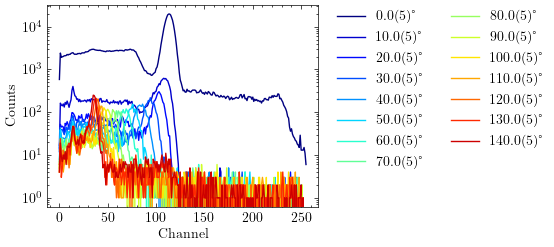

In [6]:
for i in range(len(streu_data)):
    plt.plot(streu_data[i]['channel'], streu_data[i]['counts'], label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)


plt.xlabel('Channel')
plt.ylabel('Counts')

## 3 Rückstoßelektronen

### import data

In [7]:
rueckstoss_data = pd.read_csv('Compton/data_alt/Rückstosselektronen_Punkt3/Spektrum_Rückstosselektronen.txt', sep='\t', header=None, names=['channel', 'counts'])

### analyze data

Text(0, 0.5, 'Counts')

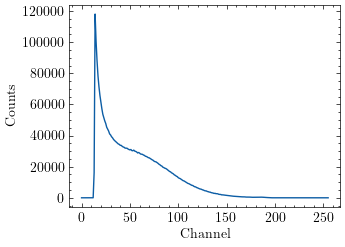

In [8]:
plt.plot(rueckstoss_data['channel'], rueckstoss_data['counts'], label='Rückstosselektronen')

plt.xlabel('Channel')
plt.ylabel('Counts')

## 4 Koinzidenz

### import data

In [9]:
koinzidenz_winkel = [30, 50, 80, 110, 140]
koinzidenz_winkel = unp.uarray(koinzidenz_winkel,0.5)
koinzidenz_data = []*len(koinzidenz_winkel)
for i in koinzidenz_winkel:
    koinzidenz_data.append(pd.read_csv(f'Compton/data_alt/Koinzidenz_Punkt4/Koinzidenz_Messung_{int(i.n)}grad.txt', sep='\t', header=None, names=['count1', 'count2']))

### analyze data

Text(0, 0.5, 'Count 2')

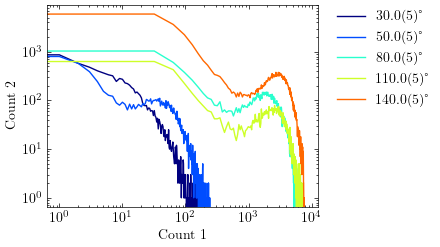

In [10]:
for i in range(len(koinzidenz_data)):
    plt.plot(koinzidenz_data[i]['count1'], koinzidenz_data[i]['count2'], label=f'{koinzidenz_winkel[i]:S}°',color=mapcolors(len(koinzidenz_data))[i])
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Count 1')
plt.ylabel('Count 2')

## 5 Energien der Photopeaks

## 6 Ruhemasse des Elektrons

## 7/8 Streuquerschnitt